<a href="https://colab.research.google.com/github/DannyCollinson/EMIT-ECOSTRESS/blob/trunk/modeling/Basic_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle
from typing import Union

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

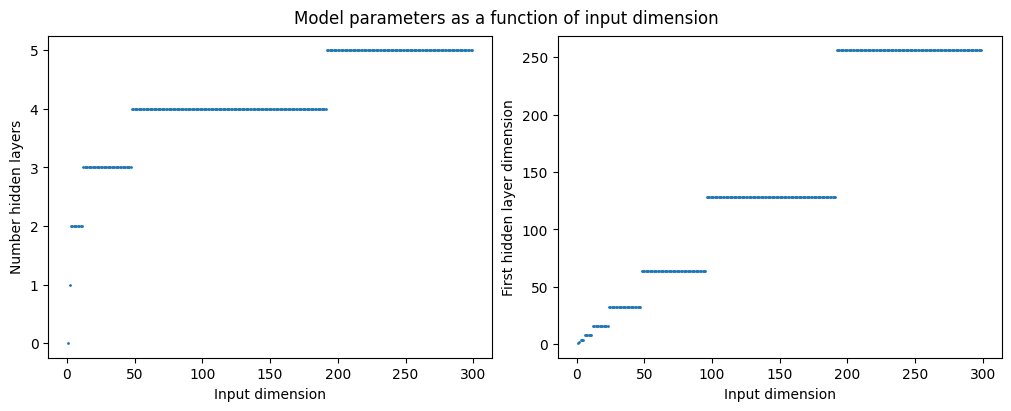

In [3]:
fig, axs = plt.subplots(1,2, figsize=(10,4), layout='constrained')
fig.suptitle('Model parameters as a function of input dimension')
x = np.arange(1, 300)
amin = np.argmin(
    [
        np.abs(2**np.ceil(np.log2(x)) - x),
        np.abs(2**np.floor(np.log2(x)) - x)
    ],
    axis=0
)
v1 = np.empty_like(x)
v2 = np.empty_like(x)
for i, v in enumerate(x):
    v1[i] = [2**np.ceil(np.log2(v)), 2**np.floor(np.log2(v))][amin[i]]
    v2[i] = np.ceil([np.ceil(np.log2(v)), np.floor(np.log2(v))][amin[i]]/1.75)
axs[1].scatter(x, v1, s=1)
axs[1].set_xlabel('Input dimension')
axs[1].set_ylabel('First hidden layer dimension')
axs[0].scatter(x, v2, s=1)
axs[0].set_xlabel('Input dimension')
axs[0].set_ylabel('Number hidden layers')
plt.show(fig)

In [12]:
class EmitEcostressDataset(Dataset):
    def __init__(
        self,
        emit_data_path: Union[str, None] = None,
        emit_data: Union[np.ndarray, None] = None,
        ecostress_data_path: Union[str, None] = None,
        ecostress_data: Union[np.ndarray, None] = None,
        additional_data_paths: Union[tuple[str], None] = None,
        additional_data: Union[tuple[np.ndarray], None] = None,
    ):
        '''
        Builds a pytorch dataset for predicting ECOSTRESS LST
        from EMIT spectra and any given additional data

        Input:
        emit_data_path: path to emit data as .npy or .pkl file,
                        not used if emit_data != None
        emit_data: 2- or 3- dimensional np array of emit data
        ecostress_data_path: path to ecostress data as .npy or .pkl file,
                             not used if ecostress_data != None
        ecostress_data: 1- or 2- dimensional np array of ecostress data
        additional_data_paths: tuple of paths to supplementary datasets
                               used for additional model input,
                               must be .npy or .pkl files
        additional_data: tuple of 1-, 2-, or 3-dimensional np arrays of
                         supplementary data used for additional model input

        * Note that emit_data and ecostress_data will take precedence
          over emit_data_path and ecostress_data_path, respectively,
          but additional_data_paths and additional_data can both be specified,
          and if additional_data_paths specifies a path to data already
          in additional_data, a duplicate will be added
        '''
        if emit_data_path != None and emit_data == None:
            if emit_data_path[-4:] == '.npy':
                emit_data = np.load(emit_data_path)
            elif emit_data_path[-4:] == '.pkl':
                emit_data = pickle.load(open(emit_data_path, 'rb'))
            else:
                raise ValueError(
                    f'emit_data_path [{emit_data_path}] has an '
                    'invalid file extension, must be .npy or .pkl'
                )
        if emit_data is not None:
            if len(emit_data.shape) == 2:
                self.emit_data = emit_data
            elif len(emit_data.shape) == 3:
                self.emit_data = emit_data.reshape(
                    (
                        emit_data.shape[0] * emit_data.shape[1],
                        emit_data.shape[2]
                    )
                )
            else:
                raise ValueError(
                    'emit_data must be 2- or 3-dimensional, '
                    f'found {len(emit_data.shape)}-dimensional'
                )
        else:
            raise ValueError(
                'Either emit_data_path or emit_data must not be None'
            )

        if ecostress_data_path != None and ecostress_data == None:
            if ecostress_data_path[-4:] == '.npy':
                ecostress_data = np.load(ecostress_data_path)
            elif ecostress_data_path[-4:] == '.pkl':
                ecostress_data = pickle.load(open(ecostress_data_path, 'rb'))
            else:
                raise ValueError(
                    f'ecostress_data_path [{ecostress_data_path}] has an '
                    'invalid file extension, must be .npy or .pkl'
                )
        if ecostress_data is not None:
            if len(ecostress_data.shape) == 1:
                self.ecostress_data = ecostress_data
            elif len(ecostress_data.shape) == 2:
                self.ecostress_data = ecostress_data.reshape(
                    ecostress_data.shape[0] * ecostress_data.shape[1]
                )
            else:
                raise ValueError(
                    'ecostress_data must be 2- or 3-dimensional, '
                    f'found {len(ecostress_data.shape)}-dimensional'
                )
        else:
            raise ValueError(
                'Either ecostress_data_path or ecostress_data must not be None'
            )

        assert self.emit_data.shape[0] == self.ecostress_data.shape[0], \
            'emit_data and ecostress_data must have the length, ' \
            f'got {self.emit_data.shape[0]} and {self.ecostress_data.shape[0]}'

        # nan_mask = np.isnan(self.emit_data)
        # self.emit_data = self.emit_data[~nan_mask]
        # self.ecostress_data = self.ecostress_data[~nan_mask[:,0]]

        # assert self.emit_data.shape[0] == self.ecostress_data.shape[0], \
        #     'emit_data and ecostress_data changed lengths during filtering, ' \
        #     f'got {self.emit_data.shape[0]} and {self.ecostress_data.shape[0]}'

        self.additional_data = []
        if additional_data != None:
            for i in range(len(additional_data)):
                if len(additional_data[i].shape) == 1:
                    self.additional_data.append(additional_data[i])
                if len(additional_data[i].shape) == 2:
                    self.additional_data.append(additional_data[i])
                elif len(additional_data[i].shape) == 3:
                    self.additional_data.append(
                        additional_data[i].reshape(
                            (
                                additional_data[i].shape[0] *
                                additional_data[i].shape[1],
                                additional_data[i].shape[2]
                            )
                        )
                    )
                else:
                    raise ValueError(
                        f'Item at index {i} in additional_data must be'
                        '1-, 2-, or 3-dimensional, '
                        f'found {len(additional_data[i].shape)}-dimensional'
                    )

        if additional_data_paths != None:
            for i in range(len(additional_data_paths)):
                if additional_data_paths[i][-4:] == '.npy':
                    additional_data_element = np.load(additional_data_paths[i])
                elif additional_data_paths[i][-4:] == '.pkl':
                    additional_data_element = pickle.load(
                        open(additional_data_paths[i], 'rb')
                    )
                else:
                    raise ValueError(
                        f'Path at index {i} [{additional_data_paths[i]}] '
                        'of additional_data_paths has an invalid '
                        'file extension, must be .npy or .pkl'
                    )
                if len(additional_data_element.shape) == 1:
                    self.additional_data.append(
                        additional_data_element.reshape(
                            (additional_data_element.shape[0], 1)
                        )
                    )
                if len(additional_data_element.shape) == 2:
                    self.additional_data.append(additional_data_element)
                elif len(additional_data_element.shape) == 3:
                    self.additional_data.append(
                        additional_data_element.reshape(
                            (
                                additional_data_element.shape[0] *
                                additional_data_element.shape[1],
                                additional_data_element.shape[2]
                            )
                        )
                    )
                else:
                    raise ValueError(
                        f'Item loaded from index {i} in additional_data_paths '
                        ' must be 1-. 2-, or 3-dimensional, found '
                        f'{len(additional_data_element.shape)}-dimensional'
                    )

        for i, additional_data_element in enumerate(self.additional_data):
            # additional_data_element = additional_data_element[~nan_mask]
            if i >= len(additional_data):
                index = i - len(additional_data)
                message = f'loaded from index {index} in additional_data_paths'
            else:
                index = i
                message = f'from index {index} in additional_data'
            assert additional_data_element.shape[0] == self.emit_data.shape[0],\
                f'emit_data and additonal data {message} must have the same ' \
                f'length, got {self.emit_data.shape[0]} ' \
                f'and {additional_data_element.shape[0]}'

        self.input_dim = (
            emit_data.shape[1] +
            sum(
                [
                    additional_data_element.shape[1]
                    for additional_data_element in self.additional_data
                ]
            )
        )


    def __len__(self):
        return self.emit_data.shape[1]


    def __getitem__(self, index: int):
        x = self.emit_data[index, :]
        for additional_data_element in self.additional_data:
            x = np.concatenate([x, additional_data_element[index, :]], axis=1)
        y = self.ecostress_data[index]
        return torch.tensor(x), torch.tensor(y)

In [119]:
# Make datasets and dataloaders
train_dataset = EmitEcostressDataset(
    emit_data_path=(
        '/content/drive/Shareddrives/emit-ecostress/Data/Train_Val_Test/emit_train_pca32.pkl'
    ),
    ecostress_data_path=(
        '/content/drive/Shareddrives/emit-ecostress/Data/Train_Val_Test/ecostress_train.pkl'
    )
)

val_dataset = EmitEcostressDataset(
    emit_data_path=(
        '/content/drive/Shareddrives/emit-ecostress/Data/Train_Val_Test/emit_val_pca32.pkl'
    ),
    ecostress_data_path=(
        '/content/drive/Shareddrives/emit-ecostress/Data/Train_Val_Test/ecostress_val.pkl'
    )
)

train_loader = DataLoader(train_dataset, batch_size=16)
val_loader = DataLoader(val_dataset, batch_size=16)

In [120]:
class DenseFeedforwardModel(nn.Module):
    '''
    Defines a pytorch model made up of dense linear layers and ReLU activation
    If argmin = argmin(abs(2**ceil(log2(x)) - x), abs(2**floor(log2(x)) - x))
    where x is the input dimension, then the number of hidden layers is
    n_hidden_layers = int(ceil([ceil(log2(x)), floor(log2(x))][argmin]/1.75)),
    and the dimension of the first hidden layer is
    dim_1 = int([2**ceil(log2(x)), 2**floor(log2(x))][argmin]),
    and dim_n+1 = dim_n / 2 for n >= 1
    '''
    def __init__(self, input_dim: int):
        super(DenseFeedforwardModel, self).__init__()
        self.argmin = np.argmin(
            [
                np.abs(2**np.ceil(np.log2(input_dim)) - input_dim),
                np.abs(2**np.floor(np.log2(input_dim)) - input_dim)
            ],
            axis=0
        )
        self.n_hidden_layers = (
            int(np.ceil(
                [
                    np.ceil(np.log2(input_dim)),
                    np.floor(np.log2(input_dim))
                ][self.argmin]/1.75
            ))
        )
        self.dim_1 = (
            int(
                [
                    2**np.ceil(np.log2(input_dim)),
                    2**np.floor(np.log2(input_dim))
                ][self.argmin]
            )
        )

        next_dim = self.dim_1
        self.linear_1 = nn.Linear(input_dim, next_dim)
        if 2 <= self.n_hidden_layers:
            next_dim = next_dim // 2
            self.linear_2 = nn.Linear(next_dim * 2, next_dim)
        if 3 <= self.n_hidden_layers:
            next_dim = next_dim // 2
            self.linear_3 = nn.Linear(next_dim * 2, next_dim)
        if 4 <= self.n_hidden_layers:
            next_dim = next_dim // 2
            self.linear_4 = nn.Linear(next_dim * 2, next_dim)
        if 5 <= self.n_hidden_layers:
            next_dim = next_dim // 2
            self.linear_5 = nn.Linear(next_dim * 2, next_dim)
        if 6 <= self.n_hidden_layers:
            next_dim = next_dim // 2
            self.linear_6 = nn.Linear(next_dim * 2, next_dim)
        if 7 <= self.n_hidden_layers:
            next_dim = next_dim // 2
            self.linear_7 = nn.Linear(next_dim * 2, next_dim)
        if 8 <= self.n_hidden_layers:
            next_dim = next_dim // 2
            self.linear_8 = nn.Linear(next_dim * 2, next_dim)
        self.linear_output = nn.Linear(next_dim, 1)


    def forward(self, x: torch.Tensor):
        x = F.relu(self.linear_1(x))
        if 2 <= self.n_hidden_layers:
            x = F.relu(self.linear_2(x))
        if 3 <= self.n_hidden_layers:
            x = F.relu(self.linear_3(x))
        if 4 <= self.n_hidden_layers:
            x = F.relu(self.linear_4(x))
        if 5 <= self.n_hidden_layers:
            x = F.relu(self.linear_5(x))
        if 6 <= self.n_hidden_layers:
            x = F.relu(self.linear_6(x))
        if 7 <= self.n_hidden_layers:
            x = F.relu(self.linear_7(x))
        if 8 <= self.n_hidden_layers:
            x = F.relu(self.linear_8(x))
        x = self.linear_output(x)

        return x.squeeze()

In [121]:
def train(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader: DataLoader,
    val_loader: Union[DataLoader, None] = None,
    n_epochs: int = 10,
    loss_interval: int = 5,
):
    train_loss = np.zeros(n_epochs)
    val_loss = np.zeros(n_epochs)
    for epoch in range(n_epochs):
        for x, y in train_loader:
            optimizer.zero_grad()
            x = x.to(dtype=torch.float, device=device)
            y = y.to(dtype=torch.float, device=device)
            x = model(x)
            loss = loss_fn(x, y)
            train_loss[epoch] += loss.item() / len(train_dataset)
            loss.backward()
            optimizer.step()
        if scheduler is not None:
            scheduler.step()

        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(dtype=torch.float, device=device)
                y = y.to(dtype=torch.float, device=device)
                x = model(x)
                val_loss[epoch] += loss_fn(x, y).item() / len(val_dataset)

        if (
            loss_interval is not None
            and (epoch % loss_interval == 0 or epoch == n_epochs - 1)
        ):
            print(
                f'Epoch {"0" * (5 - len(str(epoch))) + str(epoch + 1)}\t\t'
                f'Train Loss: {train_loss[epoch]:.5}\t\t'
                f'Val Loss: {val_loss[epoch]:.5} \t\t',
                end='',
            )
            if scheduler is not None:
                print(f'LR: {scheduler.get_last_lr()[0]:.6}')
            else:
                print('')

    return train_loss, val_loss

In [122]:
# Make model, optimizer, and loss function
n_epochs = 100000
model = DenseFeedforwardModel(train_dataset.input_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=10**-0.5)
scheduler = optim.lr_scheduler.StepLR(optimizer, n_epochs // 5, 0.5)
loss_fn = nn.MSELoss(reduction='sum')
model

DenseFeedforwardModel(
  (linear_1): Linear(in_features=32, out_features=32, bias=True)
  (linear_2): Linear(in_features=32, out_features=16, bias=True)
  (linear_3): Linear(in_features=16, out_features=8, bias=True)
  (linear_output): Linear(in_features=8, out_features=1, bias=True)
)

In [123]:
train_loss, val_loss = train(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader,
    val_loader,
    n_epochs=n_epochs,
    loss_interval=n_epochs // 10
)

Epoch 00001		Train Loss: 0.41723		Val Loss: 2.0062 		LR: 0.01
Epoch 10001		Train Loss: 0.0027032		Val Loss: 0.72019 		LR: 0.01
Epoch 20001		Train Loss: 0.0027025		Val Loss: 0.72016 		LR: 0.005
Epoch 30001		Train Loss: 0.0027015		Val Loss: 0.71996 		LR: 0.005
Epoch 40001		Train Loss: 0.0027011		Val Loss: 0.71996 		LR: 0.0025
Epoch 50001		Train Loss: 0.0027006		Val Loss: 0.71985 		LR: 0.0025
Epoch 60001		Train Loss: 0.0027004		Val Loss: 0.71985 		LR: 0.00125
Epoch 70001		Train Loss: 0.0027002		Val Loss: 0.7198 		LR: 0.00125
Epoch 80001		Train Loss: 0.0027001		Val Loss: 0.7198 		LR: 0.000625
Epoch 90001		Train Loss: 0.0026999		Val Loss: 0.71977 		LR: 0.000625
Epoch 100000		Train Loss: 0.0026999		Val Loss: 0.71977 		LR: 0.0003125


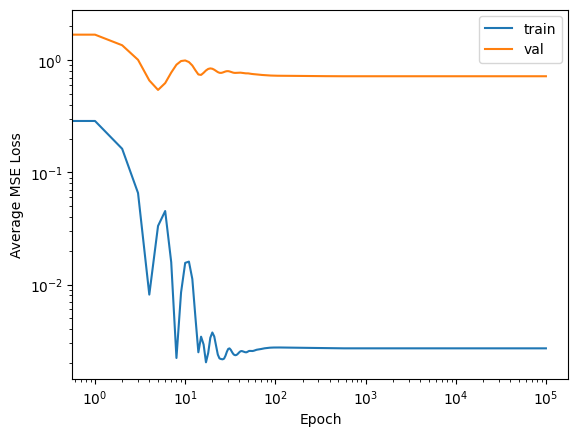

In [124]:
fig, ax = plt.subplots()
ax.loglog(np.arange(n_epochs), train_loss, label='train')
ax.loglog(np.arange(n_epochs), val_loss, label='val')
ax.set_xlabel('Epoch')
ax.set_ylabel('Average MSE Loss')
ax.legend()
plt.show(fig)

In [125]:
n_epochs = 1000
loss_fn = nn.MSELoss(reduction='sum')
lambdas = np.concatenate([np.array([0]), np.logspace(-3, 2, 21)])
losses = np.zeros((2, len(lambdas)))
for i, lam in enumerate(lambdas):
    print(f'Lambda = {lam}... ', end='')
    model = DenseFeedforwardModel(train_dataset.input_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=lam)
    scheduler = optim.lr_scheduler.StepLR(optimizer, n_epochs // 5, 0.5)

    train_loss, val_loss = train(
        model,
        optimizer,
        scheduler,
        loss_fn,
        train_loader,
        val_loader,
        n_epochs=n_epochs,
        loss_interval=None,
    )
    losses[0, i] = train_loss[-1]
    losses[1, i] = val_loss[-1]
    print('done')

Lambda = 0.0... done
Lambda = 0.001... done
Lambda = 0.0017782794100389228... done
Lambda = 0.0031622776601683794... done
Lambda = 0.005623413251903491... done
Lambda = 0.01... done
Lambda = 0.01778279410038923... done
Lambda = 0.03162277660168379... done
Lambda = 0.05623413251903491... done
Lambda = 0.1... done
Lambda = 0.1778279410038923... done
Lambda = 0.31622776601683794... done
Lambda = 0.5623413251903491... done
Lambda = 1.0... done
Lambda = 1.7782794100389228... done
Lambda = 3.1622776601683795... done
Lambda = 5.623413251903491... done
Lambda = 10.0... done
Lambda = 17.78279410038923... done
Lambda = 31.622776601683793... done
Lambda = 56.23413251903491... done
Lambda = 100.0... done


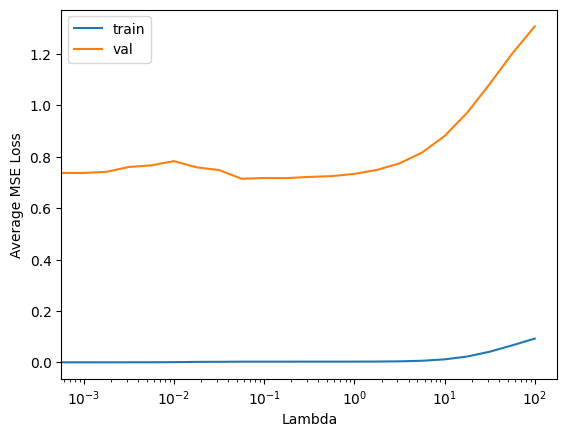

In [126]:
fig, ax = plt.subplots()
ax.semilogx(lambdas, losses[0, :], label='train')
ax.semilogx(lambdas, losses[1, :], label='val')
ax.legend()
ax.set_xlabel('Lambda')
ax.set_ylabel('Average MSE Loss')
plt.show(fig)

In [140]:
n_components_list = [1, 3, 8, 21, 32, 76, 100]
losses = np.zeros((2, len(n_components_list), 2))
n_epochs = 1000
loss_fn = nn.MSELoss(reduction='sum')
for i, white in enumerate(['', '_white']):
    for j, n_components in enumerate(n_components_list):
        if white == '':
            print(f'White = False, n = {n_components}... ', end='')
        else:
            print(f'White = True, n = {n_components}... ', end='')
        train_dataset = EmitEcostressDataset(
            emit_data_path=(
                f'/content/drive/Shareddrives/emit-ecostress/Data/Train_Val_Test/emit_train_pca{n_components}{white}.pkl'
            ),
            ecostress_data_path=(
                '/content/drive/Shareddrives/emit-ecostress/Data/Train_Val_Test/ecostress_train.pkl'
            )
        )
        val_dataset = EmitEcostressDataset(
            emit_data_path=(
                f'/content/drive/Shareddrives/emit-ecostress/Data/Train_Val_Test/emit_val_pca{n_components}{white}.pkl'
            ),
            ecostress_data_path=(
                '/content/drive/Shareddrives/emit-ecostress/Data/Train_Val_Test/ecostress_val.pkl'
            )
        )
        train_loader = DataLoader(train_dataset, batch_size=16)
        val_loader = DataLoader(val_dataset, batch_size=16)

        model = DenseFeedforwardModel(train_dataset.input_dim).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=10**-0.5)
        scheduler = optim.lr_scheduler.StepLR(optimizer, n_epochs // 5, 0.5)

        train_loss, val_loss = train(
            model,
            optimizer,
            scheduler,
            loss_fn,
            train_loader,
            val_loader,
            n_epochs=n_epochs,
            loss_interval=None,
        )

        losses[i, j, 0] = train_loss[-1]
        losses[i, j, 1] = val_loss[-1]
        print('done')

White = False, n = 1... 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


done
White = False, n = 3... done
White = False, n = 8... done
White = False, n = 21... done
White = False, n = 32... done
White = False, n = 76... done
White = False, n = 100... done
White = True, n = 1... done
White = True, n = 3... done
White = True, n = 8... done
White = True, n = 21... done
White = True, n = 32... done
White = True, n = 76... done
White = True, n = 100... done


<ipython-input-141-7d7b35522ce5>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.concatenate([np.zeros(1, dtype=int), n_components_list]))


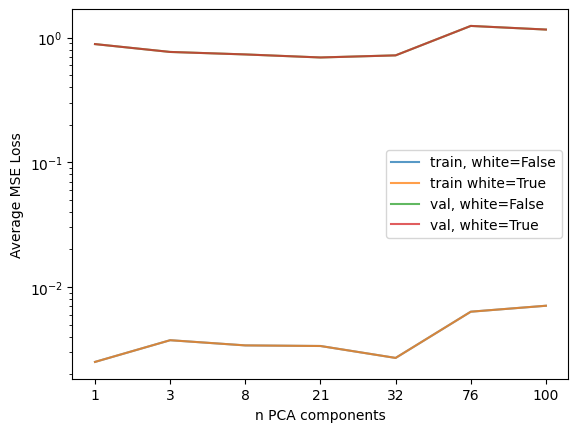

In [141]:
fig, ax = plt.subplots()
ax.semilogy(np.arange(len(n_components_list)), losses[0, :, 0], label='train, white=False', alpha=0.75)
ax.semilogy(np.arange(len(n_components_list)), losses[1, :, 0], label='train white=True', alpha=0.75)
ax.semilogy(np.arange(len(n_components_list)), losses[0, :, 1], label='val, white=False', alpha=0.75)
ax.semilogy(np.arange(len(n_components_list)), losses[1, :, 1], label='val, white=True', alpha=0.75)
ax.set_xticklabels(np.concatenate([np.zeros(1, dtype=int), n_components_list]))
ax.legend()
ax.set_xlabel('n PCA components')
ax.set_ylabel('Average MSE Loss')
plt.show(fig)